# Chapter 8. Tree-Based Methods

In [169]:
## Lab 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals.six import StringIO  
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [2]:
carseats = pd.read_csv('data/carseats.csv')
carseats.head(5)

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No

In [112]:
carseats.isna().any()

Sales          False
CompPrice      False
Income         False
Advertising    False
Population     False
Price          False
ShelveLoc      False
Age            False
Education      False
Urban          False
US             False
dtype: bool

In [113]:
carseats['High'] = np.where(carseats['Sales'] > 8,1,0)
carseats = pd.get_dummies(carseats, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)
carseats.head(4)

Sales  CompPrice  Income  Advertising  Population  Price  Age  Education  \
0   9.50        138      73           11         276    120   42         17   
1  11.22        111      48           16         260     83   65         10   
2  10.06        113      35           10         269     80   59         12   
3   7.40        117     100            4         466     97   55         14   

   High  ShelveLoc_Good  ShelveLoc_Medium  Urban_Yes  US_Yes  
0     1               0                 0          1       1  
1     1               1                 0          1       1  
2     1               0                 1          1       1  
3     0               0                 1          1       1

In [114]:
X = carseats.drop(["Sales","High"], axis=1)
y = carseats['High']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.5, random_state=0)

/home/sabin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [115]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [116]:
print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       236
           1       0.99      0.81      0.89       164

   micro avg       0.92      0.92      0.92       400
   macro avg       0.94      0.90      0.91       400
weighted avg       0.93      0.92      0.92       400



In [117]:
# confusion matrix
confusion_matrix(y, clf.predict(X))

array([[235,   1],
       [ 31, 133]])

In [118]:
print("Total accuracy {0:.4f} %".format((235 + 133)/(235+133+31+1)))


Total accuracy 0.9200 %


In [119]:
# finding terminal nodes (max_leaf) using CV... cv=10

scores = []
max_leafs_val = range(2, 50)
for leaf in max_leafs_val:
    reg_tree = DecisionTreeClassifier(max_leaf_nodes = leaf)
    sc = cross_val_score(reg_tree, X_, y, cv=10)
    scores.append((sc.mean(), sc.std()))
scores = np.array(scores)

Optimal max_leafs:  4


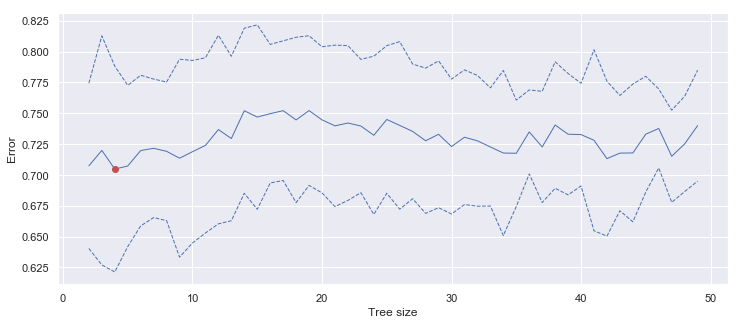

In [122]:
plt.figure(figsize=(12, 5))
plt.plot(max_leafs_val, scores[:,0], 'b', lw=1)
plt.plot(max_leafs_val, scores[:,0]+scores[:,1], 'b--', lw=1)
plt.plot(max_leafs_val, scores[:,0]-scores[:,1], 'b--', lw=1)
plt.plot(max_leafs_val[np.argmin(scores[:,0])], scores[np.argmin(scores[:,0]),0], marker='o', color='r')
plt.xlabel('Tree size')
plt.ylabel('Error')

print("Optimal max_leafs: ",max_leafs_val[np.argmin(scores[:,0])])
plt.show()


In [128]:
# The most optimal nr of nodes is 34
clf_optimal = DecisionTreeClassifier(max_leaf_nodes=4)

clf_optimal.fit(X_train, y_train)

# confusion matrix
confusion_matrix(y, clf_optimal.predict(X))

array([[197,  39],
       [ 75,  89]])

In [127]:
# Note: here to test it on the training set, that's why the result is considerably smaller than
# in the model from above where the whole dataset was used
# the results will also change for a different k-fold size.
print("Total accuracy {0:.4f} %".format((197 + 89)/(197+89+39+75)))


Total accuracy 0.7150 %


## Fitting Regression Trees

In [3]:
boston = pd.read_csv('data/boston.csv')
boston.head(5)

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

In [135]:
boston.isna().any()

crim       False
zn         False
indus      False
chas       False
nox        False
rm         False
age        False
dis        False
rad        False
tax        False
ptratio    False
black      False
lstat      False
medv       False
dtype: bool

In [137]:
X = boston.drop("medv", axis=1)
y = boston['medv']

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

## select 3 from the book
reg_tree = DecisionTreeRegressor(random_state=0, max_depth=3)
reg_tree.fit(X_train, y_train)
y_pred = reg_tree.predict(X_test)
print(mean_squared_error(y_test,y_pred))



26.02323085009744


### Bagging, RandomForest

In [142]:
bagging_reg = BaggingRegressor(random_state=1, max_features=13).fit(X_train, y_train)
pred = bagging_reg.predict(X_test)
print(mean_squared_error(y_test, pred))



18.024477470355727


Text(0, 0.5, 'y_test')

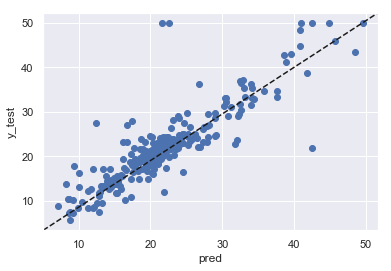

In [143]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')


In [146]:
rf = RandomForestRegressor(random_state=1, max_features=13).fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(mean_squared_error(y_test, y_pred))

# For the same nr of max_features = 13, RandomForest outperforms bagging

18.290404743083002


/home/sabin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


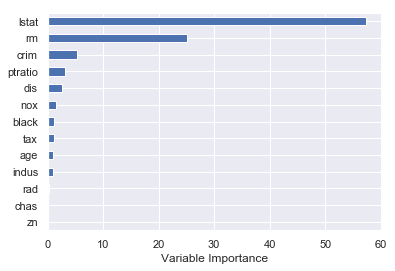

In [150]:
Importance = pd.DataFrame({'Importance':rf.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='b', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [158]:
## Boosting

boost = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01,max_depth=4, random_state=1).fit(X_train, y_train)
mean_squared_error(y_test, boost.predict(X_test))


17.483377479729086

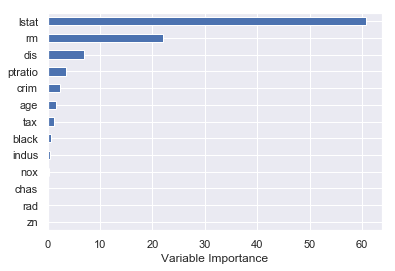

In [159]:
Importance = pd.DataFrame({'Importance':boost.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='b', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

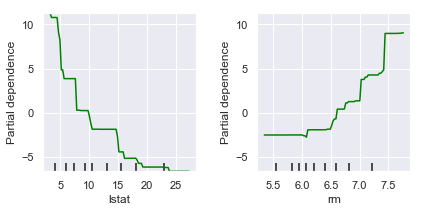

In [155]:
fig,axs = plot_partial_dependence(boost, X_train, features=[12,5],
                                 feature_names=X_train.columns,
                                 grid_resolution=100)

# Applied

In [4]:
## 7
# we use the boston dataset from above, but initiate again the X and y

boston.head(5)

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

In [6]:
X = boston.iloc[:, :-1]
y = boston['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=12)

In [34]:
error_rate =[]

max_features = {'p':X.shape[1],'p/2':int(len(X_train.columns)/2), 'sqrt(p)':'sqrt','1':1 }

for f in max_features:
    for i in range(1, 100):
        rf = RandomForestRegressor(random_state=1, max_features=max_features[f],
                                  n_estimators=i).fit(X_train, y_train)
        error_rate += [[f , i, mean_squared_error(y_test, rf.predict(X_test))]]




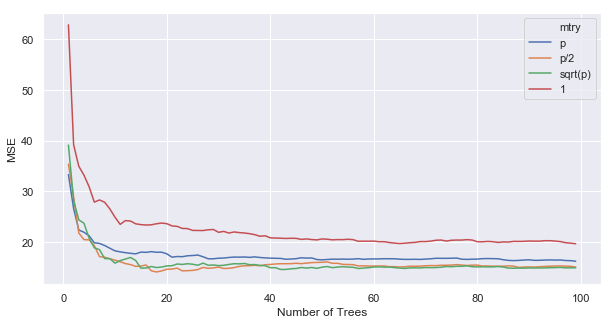

In [39]:
plt.figure(figsize=(10,5))
sns.lineplot(x='Number of Trees', y='MSE', hue='mtry', 
             data=pd.DataFrame(error_rate, columns=[ 'mtry','Number of Trees', 'MSE']));

As the number of trees increases the performance of the algorithms improves. For lower number of trees,
 p/2 performs the best while for a higher nr of trees [40, 60] sqrt(p) is better. As the nr of trees reaches 100, 
    MSE for both p/2 and sqrt(p) looks similar.

In [45]:
# 8
# we need the unmodified data
carseats = pd.read_csv('data/carseats.csv')
carseats = pd.get_dummies(carseats, drop_first=True)
X = carseats.drop('Sales',axis=1)
y = carseats['Sales']

In [47]:
# Again we use a 50% split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=12)

tree = DecisionTreeRegressor(random_state=17).fit(X_train, y_train)

print("RMSE: {0:.5f}".format(mean_squared_error(y_test, tree.predict(X_test))))

RMSE: 6.72100


In [50]:
## c.) 
# we use a grid search to eastimate the optimal nr of max_leaf_nodes
tree_cv = GridSearchCV(DecisionTreeRegressor(random_state=17),
                  param_grid={'max_leaf_nodes' : range(2, 50)},
                  return_train_score=True)

tree_cv.fit(X_train, y_train)

/home/sabin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/sabin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=17, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_leaf_nodes': range(2, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [51]:
# the best estimator has max leaf nodes 10
tree_cv.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=17, splitter='best')

In [56]:
# we use the results of the grid search with the most optimal params, 
# and see that pruning improves the performance
tree_cv_best = tree_cv.best_estimator_.fit(X_train, y_train)

print("MSE : {0:.5f} " .format(mean_squared_error(y_test, tree_cv_best.predict(X_test))))

MSE : 5.25977 


In [64]:
# d.)

bag_reg = BaggingRegressor(random_state=12).fit(X_train, y_train)

print("Bagging MSE: {0:.4f} \n".format(mean_squared_error(y_test, bag_reg.predict(X_test))))

# feature importance
feature_importance = np.mean([tree.feature_importances_ for tree in bag_reg.estimators_], axis=0)

print(" Feature importance")
    
pd.Series(feature_importance, X_train.columns).sort_values(ascending=False)

Bagging MSE: 2.8542 

 Feature importance


Price               0.331551
ShelveLoc_Good      0.200622
CompPrice           0.119525
Age                 0.089770
ShelveLoc_Medium    0.059992
Advertising         0.057392
Income              0.054343
Population          0.050216
Education           0.023940
US_Yes              0.007924
Urban_Yes           0.004724
dtype: float64

In [66]:
# e.) 

rf = RandomForestRegressor().fit(X_train, y_train)

print("RandomForest MSE: {0:.5f} " .format(mean_squared_error(y_test, rf.predict(X_test))))
print("Feature Importance")

pd.Series(rf.feature_importances_, X.columns).sort_values(ascending=False)


RandomForest MSE: 3.12415 
Feature Importance


/home/sabin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Price               0.300682
ShelveLoc_Good      0.208298
CompPrice           0.104926
Age                 0.101378
Advertising         0.087145
Population          0.054582
Income              0.052050
ShelveLoc_Medium    0.047070
Education           0.024712
US_Yes              0.012345
Urban_Yes           0.006812
dtype: float64

In [2]:
# 9

oj = pd.read_csv('data/oj.csv')
oj.drop('Unnamed: 0', axis=1, inplace=True)
oj.head(5)

Purchase  WeekofPurchase  StoreID  PriceCH  PriceMM  DiscCH  DiscMM  \
0       CH             237        1     1.75     1.99    0.00     0.0   
1       CH             239        1     1.75     1.99    0.00     0.3   
2       CH             245        1     1.86     2.09    0.17     0.0   
3       MM             227        1     1.69     1.69    0.00     0.0   
4       CH             228        7     1.69     1.69    0.00     0.0   

   SpecialCH  SpecialMM   LoyalCH  SalePriceMM  SalePriceCH  PriceDiff Store7  \
0          0          0  0.500000         1.99         1.75       0.24     No   
1          0          1  0.600000         1.69         1.75      -0.06     No   
2          0          0  0.680000         2.09         1.69       0.40     No   
3          0          0  0.400000         1.69         1.69       0.00     No   
4          0          0  0.956535         1.69         1.69       0.00    Yes   

   PctDiscMM  PctDiscCH  ListPriceDiff  STORE  
0   0.000000   0.000000           0.24      1  
1   0.150754   0.000000           0.24      1  
2   0.000000   0.091398           0.23      1  
3   0.000000   0.000000           0.00      1  
4   0.000000   0.000000           0.00      0

In [4]:
oj = pd.get_dummies(oj, drop_first=True)
oj.head(5)

WeekofPurchase  StoreID  PriceCH  PriceMM  DiscCH  DiscMM  SpecialCH  \
0             237        1     1.75     1.99    0.00     0.0          0   
1             239        1     1.75     1.99    0.00     0.3          0   
2             245        1     1.86     2.09    0.17     0.0          0   
3             227        1     1.69     1.69    0.00     0.0          0   
4             228        7     1.69     1.69    0.00     0.0          0   

   SpecialMM   LoyalCH  SalePriceMM  SalePriceCH  PriceDiff  PctDiscMM  \
0          0  0.500000         1.99         1.75       0.24   0.000000   
1          1  0.600000         1.69         1.75      -0.06   0.150754   
2          0  0.680000         2.09         1.69       0.40   0.000000   
3          0  0.400000         1.69         1.69       0.00   0.000000   
4          0  0.956535         1.69         1.69       0.00   0.000000   

   PctDiscCH  ListPriceDiff  STORE  Purchase_MM  Store7_Yes  
0   0.000000           0.24      1            0           0  
1   0.000000           0.24      1            0           0  
2   0.091398           0.23      1            0           0  
3   0.000000           0.00      1            1           0  
4   0.000000           0.00      0            0           1

In [5]:
X = oj.drop(['Purchase_MM'], axis=1)
y = oj['Purchase_MM']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=800, random_state=21)

/home/sabin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
# Fit Sklearns tree classifier
tree = DecisionTreeClassifier(min_samples_leaf=5).fit(X_train, y_train)

print('training accuracy: {}'.format(np.around(tree.score(X_train, y_train), 3)))
# nr of leaves 
print('Nr of nodes: ' ,tree.tree_.node_count)

training accuracy: 0.89
Nr of nodes:  147


In [14]:
## Issues with plotting the tree =-----> needs to be solved


# test error
test_error = 1-np.mean(tree.predict(X_test)==y_test)
print('Test Error Rate = ', test_error)

# confusion matrix
print(confusion_matrix(y_test, tree.predict(X_test)))

print((136+77)/(136+26+31+77))


Test Error Rate =  0.21111111111111114
[[136  26]
 [ 31  77]]
0.7888888888888889


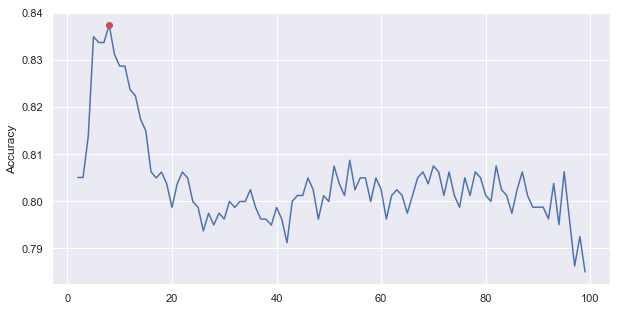

8


In [69]:
# h.) optimal tree

results = []
for sample in np.arange(2, 100):
    clf_tree = DecisionTreeClassifier(max_leaf_nodes=sample)
    score = cross_val_score(clf_tree, X_train, y_train, cv=10)
    results += [np.mean(score)]


plt.figure(figsize=(10,5))
plt.plot(range(2,100),results)
plt.plot(range(2,100)[np.argmax(results)], max(results), marker='o', color='r')

plt.ylabel('Accuracy')
plt.xlabel("")
plt.show();
print(range(2,100)[np.argmax(results)])

In [70]:
# use the result of the most optimal tree
opt_tree = DecisionTreeClassifier(max_leaf_nodes=8).fit(X_train,y_train)
opt_tree.tree_.max_depth

5

In [74]:
## by pruning we increase the bias and decrease the variance
unpruned_tree = DecisionTreeClassifier().fit(X_train,y_train)
pruned_tree = DecisionTreeClassifier(max_leaf_nodes=8).fit(X_train, y_train)

print("unpruned train", unpruned_tree.score(X_train, y_train))
print("pruned train", pruned_tree.score(X_train, y_train))
print("unpruned test", unpruned_tree.score(X_test, y_test))
print("pruned tree", pruned_tree.score(X_test,y_test))


unpruned train 0.99125
pruned train 0.84125
unpruned test 0.7481481481481481
pruned tree 0.8111111111111111


In [95]:
#     10

hitters = pd.read_csv('data/hitters.csv')
hitters.isna().any()

Unnamed: 0    False
AtBat         False
Hits          False
HmRun         False
Runs          False
RBI           False
Walks         False
Years         False
CAtBat        False
CHits         False
CHmRun        False
CRuns         False
CRBI          False
CWalks        False
League        False
Division      False
PutOuts       False
Assists       False
Errors        False
Salary         True
NewLeague     False
dtype: bool

In [96]:
# there are some missing values
hitters.dropna()
# log transform the Salary
hitters['Salary'] = np.log(hitters['Salary'])

#transform the ualitative data
hitters = pd.get_dummies(data=hitters, columns=['League', 'Division', 'NewLeague'])


In [97]:
hitters = hitters.dropna()
hitters.head(5)

Unnamed: 0  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  \
1        -Alan Ashby    315    81      7    24   38     39     14    3449   
2       -Alvin Davis    479   130     18    66   72     76      3    1624   
3      -Andre Dawson    496   141     20    65   78     37     11    5628   
4  -Andres Galarraga    321    87     10    39   42     30      2     396   
5   -Alfredo Griffin    594   169      4    74   51     35     11    4408   

   CHits  ...  PutOuts  Assists  Errors    Salary  League_A  League_N  \
1    835  ...      632       43      10  6.163315         0         1   
2    457  ...      880       82      14  6.173786         1         0   
3   1575  ...      200       11       3  6.214608         0         1   
4    101  ...      805       40       4  4.516339         0         1   
5   1133  ...      282      421      25  6.620073         1         0   

   Division_E  Division_W  NewLeague_A  NewLeague_N  
1           0           1            0            1  
2           0           1            1            0  
3           1           0            0            1  
4           1           0            0            1  
5           0           1            1            0  

[5 rows x 24 columns]

In [102]:
X = hitters.drop(['Salary','Unnamed: 0'], axis=1)
y = hitters['Salary']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=200, random_state=332)

/home/sabin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


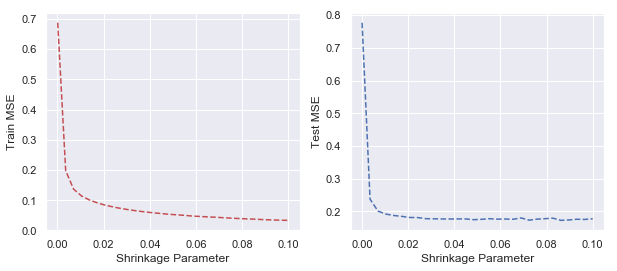

In [108]:
# boosting 


train_mse = []
test_mse = []
for rate in np.linspace(0.0001, 0.1, 30):
    boost = GradientBoostingRegressor(loss='ls', learning_rate=rate, n_estimators=1000,
                                      max_depth=1, random_state=0)
    # fit the the model to our data
    boost_est = boost.fit(X_train, y_train)
    
    # mse for train
    train_mse.append(mean_squared_error(y_train, boost_est.predict(X_train)))
    
    # mse for test
    test_mse.append(mean_squared_error(y_test, boost_est.predict(X_test)))
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
# Training MSE
ax1.plot(np.linspace(.0001,.1, 30), train_mse, color='r', linestyle='--');
ax1.set_xlabel('Shrinkage Parameter');
ax1.set_ylabel('Train MSE');
# Testing MSE
ax2.plot(np.linspace(.0001,.1, 30), test_mse, color='b', linestyle='--');
ax2.set_xlabel('Shrinkage Parameter');
ax2.set_ylabel('Test MSE');



In [112]:
# compare with linear regression

lr = LinearRegression(normalize=True).fit(X_train,y_train)
print(" MSE: {0:.5f}".format(mean_squared_error(y_test, lr.predict(X_test))))

 MSE: 0.49200


In [121]:
# compare with Lasso model

alpha = 10**np.linspace(-4,2,100)

# we find the optimal alpha for the train dataset
np.random.seed(0)
lasso_cv = LassoCV(alphas=alpha, normalize=True, max_iter=10000, cv=10)
lasso_cv.fit(X_train,y_train)
lasso_cv.alpha_

lasso = Lasso(alpha=lasso_cv.alpha_, normalize=True, max_iter=10000)
lasso.fit(X_train, y_train)
        
print("MSE for test dataset of the Lasso = ", mean_squared_error(y_test, lasso.predict(X_test)))


MSE for test dataset of the Lasso =  0.4521426110823247


the result is worse than simple linear regression. Apparently the Lasso model tends to overfit the data.

In [122]:
print(" Feature importance")
    
pd.Series(boost.feature_importances_, X_train.columns).sort_values(ascending=False)

 Feature importance


CAtBat         0.298931
CHits          0.168801
CRuns          0.093368
Years          0.065898
CRBI           0.064595
Hits           0.062977
CWalks         0.056355
CHmRun         0.054700
Walks          0.054197
AtBat          0.021151
PutOuts        0.020612
RBI            0.013936
HmRun          0.007617
Runs           0.007179
Errors         0.005432
NewLeague_A    0.001957
Assists        0.001269
NewLeague_N    0.001026
League_A       0.000000
League_N       0.000000
Division_E     0.000000
Division_W     0.000000
dtype: float64

In [123]:
# check for the Bagging approach
# it is still necessary to implement a GridSearch to find the best hyperparameters

bagging = BaggingRegressor(random_state=0, n_estimators=500).fit(X_train,y_train)

print("Bagging Test MSE = ", mean_squared_error(y_test, bagging.predict(X_test)))

Bagging Test MSE =  0.19305001357908963


In [126]:
# 11 


caravan = pd.read_csv('data/caravan.csv')
caravan.head(5)



MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  MGODOV  \
0       33         1        3         2         8       0       5       1   
1       37         1        2         2         8       1       4       1   
2       37         1        2         2         8       0       4       2   
3        9         1        3         3         3       2       3       2   
4       40         1        4         2        10       1       4       1   

   MGODGE  MRELGE  ...  APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  APLEZIER  \
0       3       7  ...         0        0        0       1        0         0   
1       4       6  ...         0        0        0       1        0         0   
2       4       3  ...         0        0        0       1        0         0   
3       4       5  ...         0        0        0       1        0         0   
4       4       7  ...         0        0        0       1        0         0   

   AFIETS  AINBOED  ABYSTAND  Purchase  
0       0        0         0        No  
1       0        0         0        No  
2       0        0         0        No  
3       0        0         0        No  
4       0        0         0        No  

[5 rows x 86 columns]

In [130]:
X = caravan.drop('Purchase', axis=1)
y = caravan['Purchase']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=1000, random_state=2)

/home/sabin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [136]:
boost = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000, max_depth=3, 
                                     random_state=0)
boost = boost.fit(X_train, y_train)

# feature importance of the GradinetBoosting model

pd.Series(boost.feature_importances_, X_train.columns).sort_values(ascending=False)[:10]

PPERSAUT    0.078620
MOSTYPE     0.043874
MINK7512    0.042944
MGODGE      0.040013
MOPLMIDD    0.038971
MSKB1       0.036876
MOPLHOOG    0.036871
PBRAND      0.035782
MGODOV      0.034161
MRELGE      0.032508
dtype: float64

In [184]:
# c.)

pred_purchase = np.where(boost.predict_proba(X_test)[:,1] > 0.2, "Yes", "No")
                      
#confusion matrix
confusion_matrix(y_test, pred_purchase)

array([[4321,  213],
       [ 228,   60]])

In [188]:
print("Accuracy of the model: ",(4321 + 60)/(4321+213+228+60))
print("Probability that predction is Yes giving that it is acctualy Yes ", (60)/(60 + 213))

Accuracy of the model:  0.9085441725425135
Probability that predction is Yes giving that it is acctualy Yes  0.21978021978021978


In [191]:
# the test for KNN for 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train,y_train)

# if the yes probability exceeds 0.2 then assign it as a purchase
knn_pred = np.where(knn.predict_proba(X_test)[:,1] > 0.2,"Yes", "No")

# confusion matrix
confusion_matrix(y_test, knn_pred)


array([[4367,  167],
       [ 255,   33]])

In [192]:
print("Model accuracy: ",(4367+33)/(4367 + 167+255+33))
print("Probability that predction is Yes giving that it is acctualy Yes ", (33)/(167 + 33))

Model accuracy:  0.9124844462878474
Probability that predction is Yes giving that it is acctualy Yes  0.165


 The GradientBoosting model performs better than the KNN model.